In [42]:
import pandas as pd
import numpy as np 
import math 
import seaborn as sns

from df_information import DataFrameInfo
from data_transform import DataTransform
from df_transform import DataFrameTransform
from plotter import Plotter

### Loading variables 

In [43]:
# load the data into df
df = pd.read_csv('../loan_payments.csv')

In [44]:
# df_info contains methods that generate useful information about the DataFrame
df_info = DataFrameInfo(df)

# to do conversions on columns of data (e.g. changing its dtype, or date formats)
data_formatter = DataTransform(df)

# A df_transformer performs EDA transformations on the dataframe e.g. imputation
df_transformer = DataFrameTransform(df)

# A class to plot helpful visuals
plotter = Plotter()

DataFrameTransform loaded...


### Summary statistics 

Calling a few basic functions to get an overview of the dataframe. Calls like .head(), .info, .shape and .describe()

In [45]:
df.head()

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,...,0.0,0.0,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,...,0.0,0.0,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,...,0.0,0.0,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,...,0.0,0.0,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,...,0.0,0.0,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL


In [46]:
df.shape

(54231, 43)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           54231 non-null  int64  
 1   member_id                    54231 non-null  int64  
 2   loan_amount                  54231 non-null  int64  
 3   funded_amount                51224 non-null  float64
 4   funded_amount_inv            54231 non-null  float64
 5   term                         49459 non-null  object 
 6   int_rate                     49062 non-null  float64
 7   instalment                   54231 non-null  float64
 8   grade                        54231 non-null  object 
 9   sub_grade                    54231 non-null  object 
 10  employment_length            52113 non-null  object 
 11  home_ownership               54231 non-null  object 
 12  annual_inc                   54231 non-null  float64
 13  verification_sta

### Correct the column formats 

##### Dates

In [48]:
# Note how the ouptut format is 'Jan-2021'. we want it to be '2022-01-01'.
# The type of the column is also 'object', and not some kind of date.
df['issue_date'].head()

0    Jan-2021
1    Jan-2021
2    Jan-2021
3    Jan-2021
4    Jan-2021
Name: issue_date, dtype: object

In [49]:
# Columns which are currently objects, but need to be converted to dates 
object_to_date_columns = df[['issue_date', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date']]

data_formatter.convert_object_columns_to_date(df, column_list=object_to_date_columns, current_format="%b-%Y")

In [50]:
# The output confirms that the format has changed.
df['last_payment_date'].head()

0   2022-01-01
1   2022-01-01
2   2021-10-01
3   2021-06-01
4   2022-01-01
Name: last_payment_date, dtype: datetime64[ns]

##### Categories 

In [51]:
# Columns which are object types, but are to be converted to categorical types
obj_into_category_columns = df[['grade', 'sub_grade', 'employment_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'earliest_credit_line', 'application_type']]
data_formatter.convert_object_columns_into_categories(df, obj_into_category_columns)


The `term` column contains only two values: `[36 months, 60 months]`.

I will convert them to categories since no more data is to be added, and these might represent fixed categories offered by banks. 

In [52]:
df['term'] = df['term'].astype("category")

Payment plan is a boolean value that can only be yes or no. I will make it categorical so it does not inferfere with operations on integer columns down the line. 

In [53]:
df['payment_plan']  = df['payment_plan'].astype("category")

There are some numeric columns, where the vast majority of values are a single value, and the rest are spread out in low numbers. 

Such columns cannot be normally distributed easily, and so I will convert them into categorical columns with ranges to group thier values. 

In [54]:
columns_to_be_categories = ["collection_recovery_fee", "collections_12_mths_ex_med", "recoveries", "total_rec_late_fee", "delinq_2yrs", "inq_last_6mths", "annual_inc"]
for column_name in columns_to_be_categories:
    df[column_name] = data_formatter.int64_to_category_with_ranges(df, df[column_name])


#### Numeric

In [55]:
# These four columns all represent a number of months, and so can be cast to int64s
float64_columns_into_int64 = df[['mths_since_last_major_derog', 'mths_since_last_delinq', 'mths_since_last_record']]

df = data_formatter.convert_float64_columns_into_int64s(df, float64_columns_into_int64)

### Handle null values

I will first identify the variables with missing values and determine the percentage of missing values in each variable.

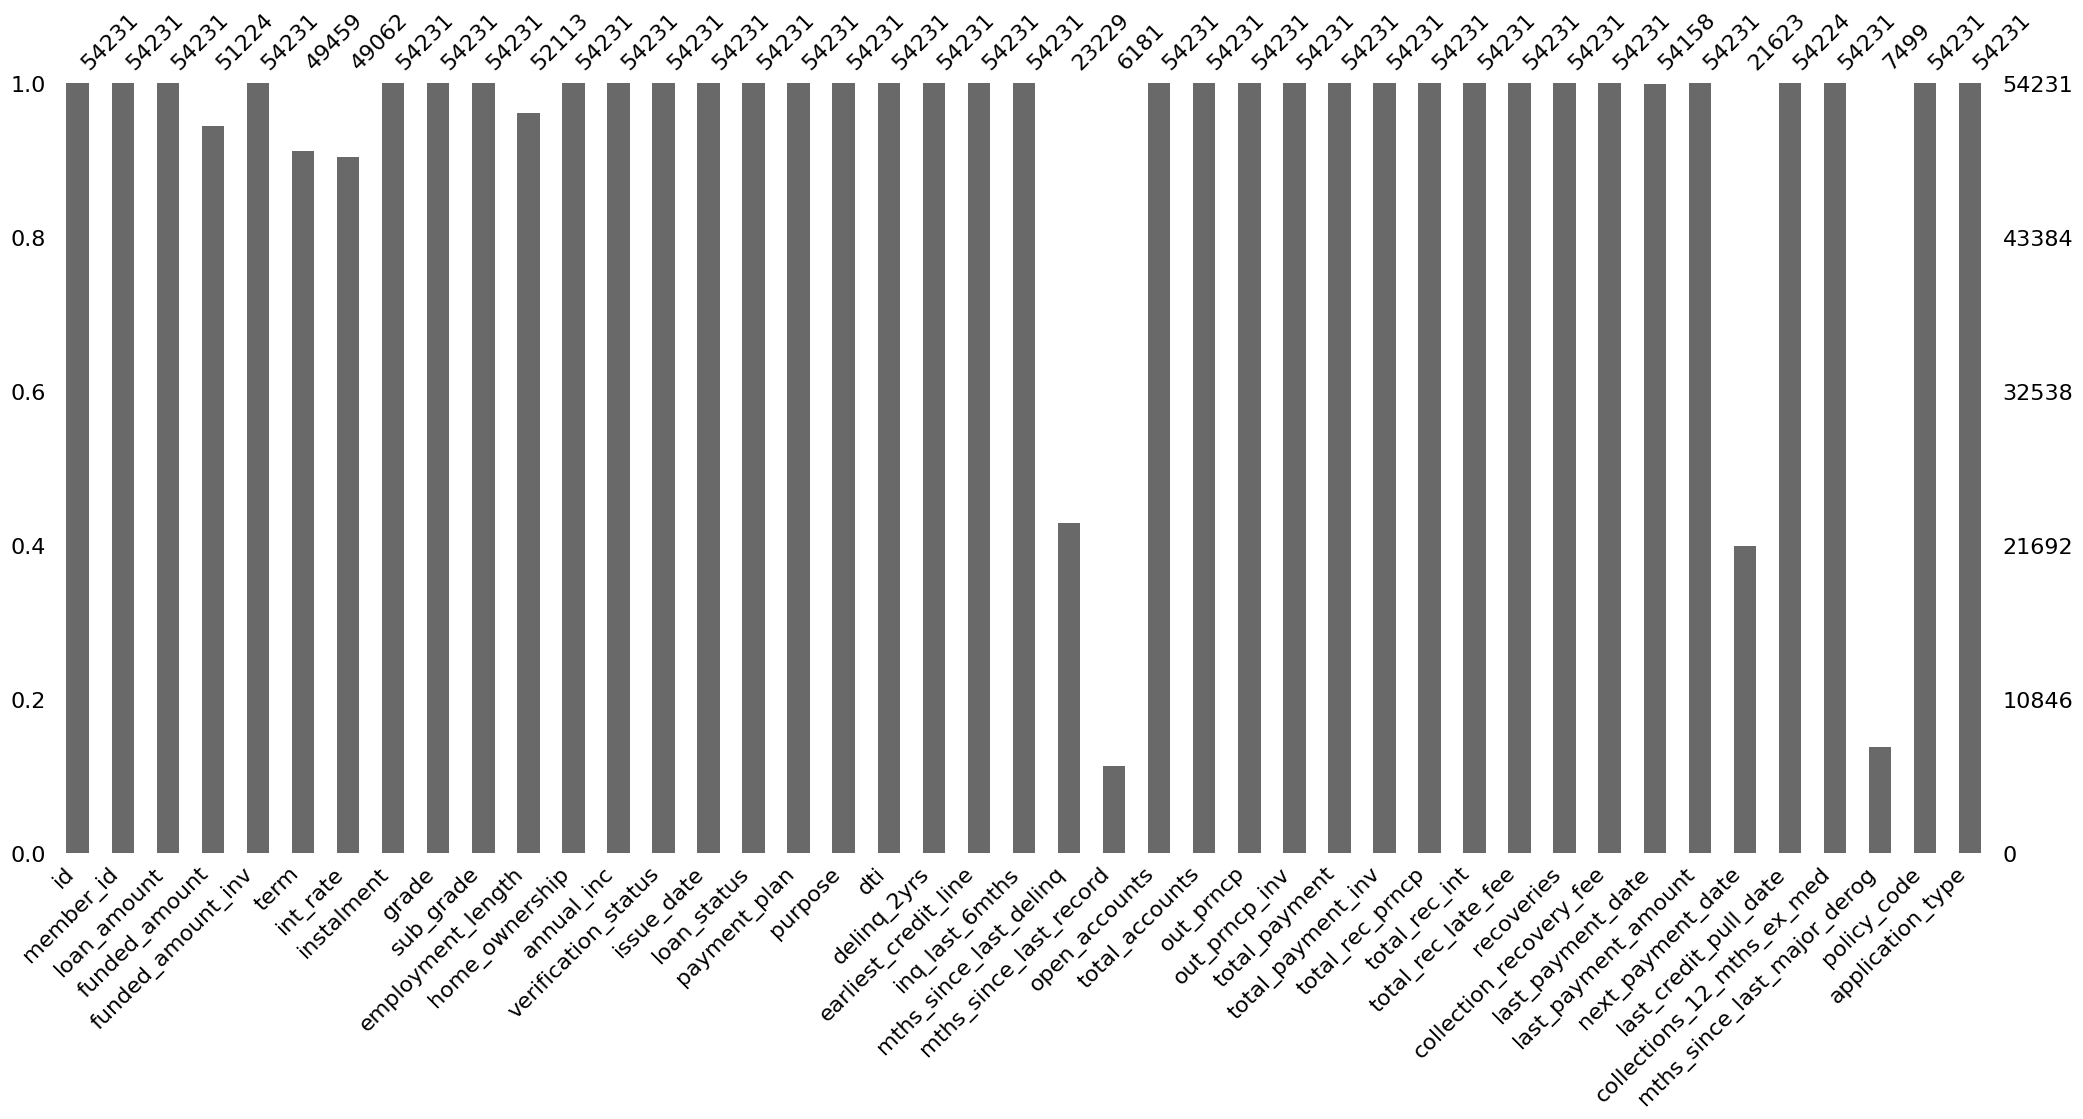

In [56]:
plot = plotter.show_null_bar_chart(df)

In [57]:

message, progress = df_info.print_null_removal_progress(df)
print(message)
progress


I have 10 columns to deal with:



,% of nulls,# of nulls,dtype
mths_since_last_record,88.60,48050,Int64
mths_since_last_major_derog,86.17,46732,Int64
next_payment_date,60.13,32608,datetime64[ns]
mths_since_last_delinq,57.17,31002,Int64
int_rate,9.53,5169,float64
term,8.80,4772,category
funded_amount,5.54,3007,float64
employment_length,3.91,2118,category
last_payment_date,0.13,73,datetime64[ns]
last_credit_pull_date,0.01,7,datetime64[ns]


#### Dropping columns

**I now will decide which of the above columns are worth dropping entirely, and proceed to do so.**

Based on the above there are 4 columns with very high proportions of nulls:

`[88.60%, 86.17%, 60.13%, 57.17%]`

The next biggest is 9.53%. 

As a result I am going to *remove all columns with >50% null values*.

In [58]:
# returns a series showing the % of null values for every column in the dataframe
percent_of_nulls = df_info.percentage_of_nulls_in_data_frame(df)

# Extract columns whose majority (> 50%) of values are null, to pass into drop()
more_than_half_null_cols = percent_of_nulls[percent_of_nulls > 50.00]

# Drop the selected columns in place from the dataframe
df = df_transformer.drop_columns(df, more_than_half_null_cols)

This is not to do with null handling, but I noticed that the policy_code column has a value of 1 for every single entry, so the column itself is not of any use to our analysis. 

Since we have a lot of other columns to attend to, I will drop the policy_code column to remove it from the data going forward. 

In [59]:
df = df_transformer.drop_column(df, df['policy_code'])

#### Imputing

There are **7 columns** left which contain null values: 

- `1` is of type `category`  
- `1` is of type `Int64`.
- `2` are of a `date` type. 
- `3` are of type `float64`. 

In [60]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

I have 6 columns to deal with:



,% of nulls,# of nulls,dtype
int_rate,9.53,5169,float64
term,8.80,4772,category
funded_amount,5.54,3007,float64
employment_length,3.91,2118,category
last_payment_date,0.13,73,datetime64[ns]
last_credit_pull_date,0.01,7,datetime64[ns]


##### Mode imputations

The column `(term)` only has two values. 

- 36.0 occurs 35845 times
- 60.0 occurs 13614 times

There could be a relationship between this value and the other variables worth exploring, but for now I will impute the missing values with the mode. 

In [61]:
df['term'] = df_transformer.impute_nulls_in_column(df['term'], 'mode')

The column `employment_length` is categorical and so mode is the most appropriate replacement. 

Since ~ 4% of its values are null, doing this may skew the data. I can address this later.

In [62]:
df['employment_length'] = df_transformer.impute_nulls_in_column(df['employment_length'], 'mode')

In [63]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

I have 4 columns to deal with:



,% of nulls,# of nulls,dtype
int_rate,9.53,5169,float64
funded_amount,5.54,3007,float64
last_payment_date,0.13,73,datetime64[ns]
last_credit_pull_date,0.01,7,datetime64[ns]


##### Median imputations

For this stage I am simply going to use the average to impute `int_rate` and `funded_amount`.

In [64]:
df['int_rate'] = df_transformer.impute_nulls_in_column(df['int_rate'], 'median')

In [65]:
df['funded_amount'] = df_transformer.impute_nulls_in_column(df['funded_amount'], 'median')

In [66]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

I have 2 columns to deal with:



,% of nulls,# of nulls,dtype
last_payment_date,0.13,73,datetime64[ns]
last_credit_pull_date,0.01,7,datetime64[ns]


#### Dropping rows 

We have three rows left:

- The `last_credit_pull_date` column has `7` null values, or `~0.01%` of them.
- The `collections_12_mths_ex_med` column has `51` null values, or `~0.09%` of them.
- The `last_payment_date` column has `73` null values, or `~0.13%` of them

I am going to delete all of the corresponding rows. 

In [67]:
df = df_transformer.drop_rows_of_null_column_entries(df, df['last_credit_pull_date'])

df = df_transformer.drop_rows_of_null_column_entries(df, df['collections_12_mths_ex_med'])

df = df_transformer.drop_rows_of_null_column_entries(df, df['last_payment_date'])

#### Confirm all nulls removed 

In [68]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

I have 0 columns to deal with:



,% of nulls,# of nulls,dtype


<Axes: >

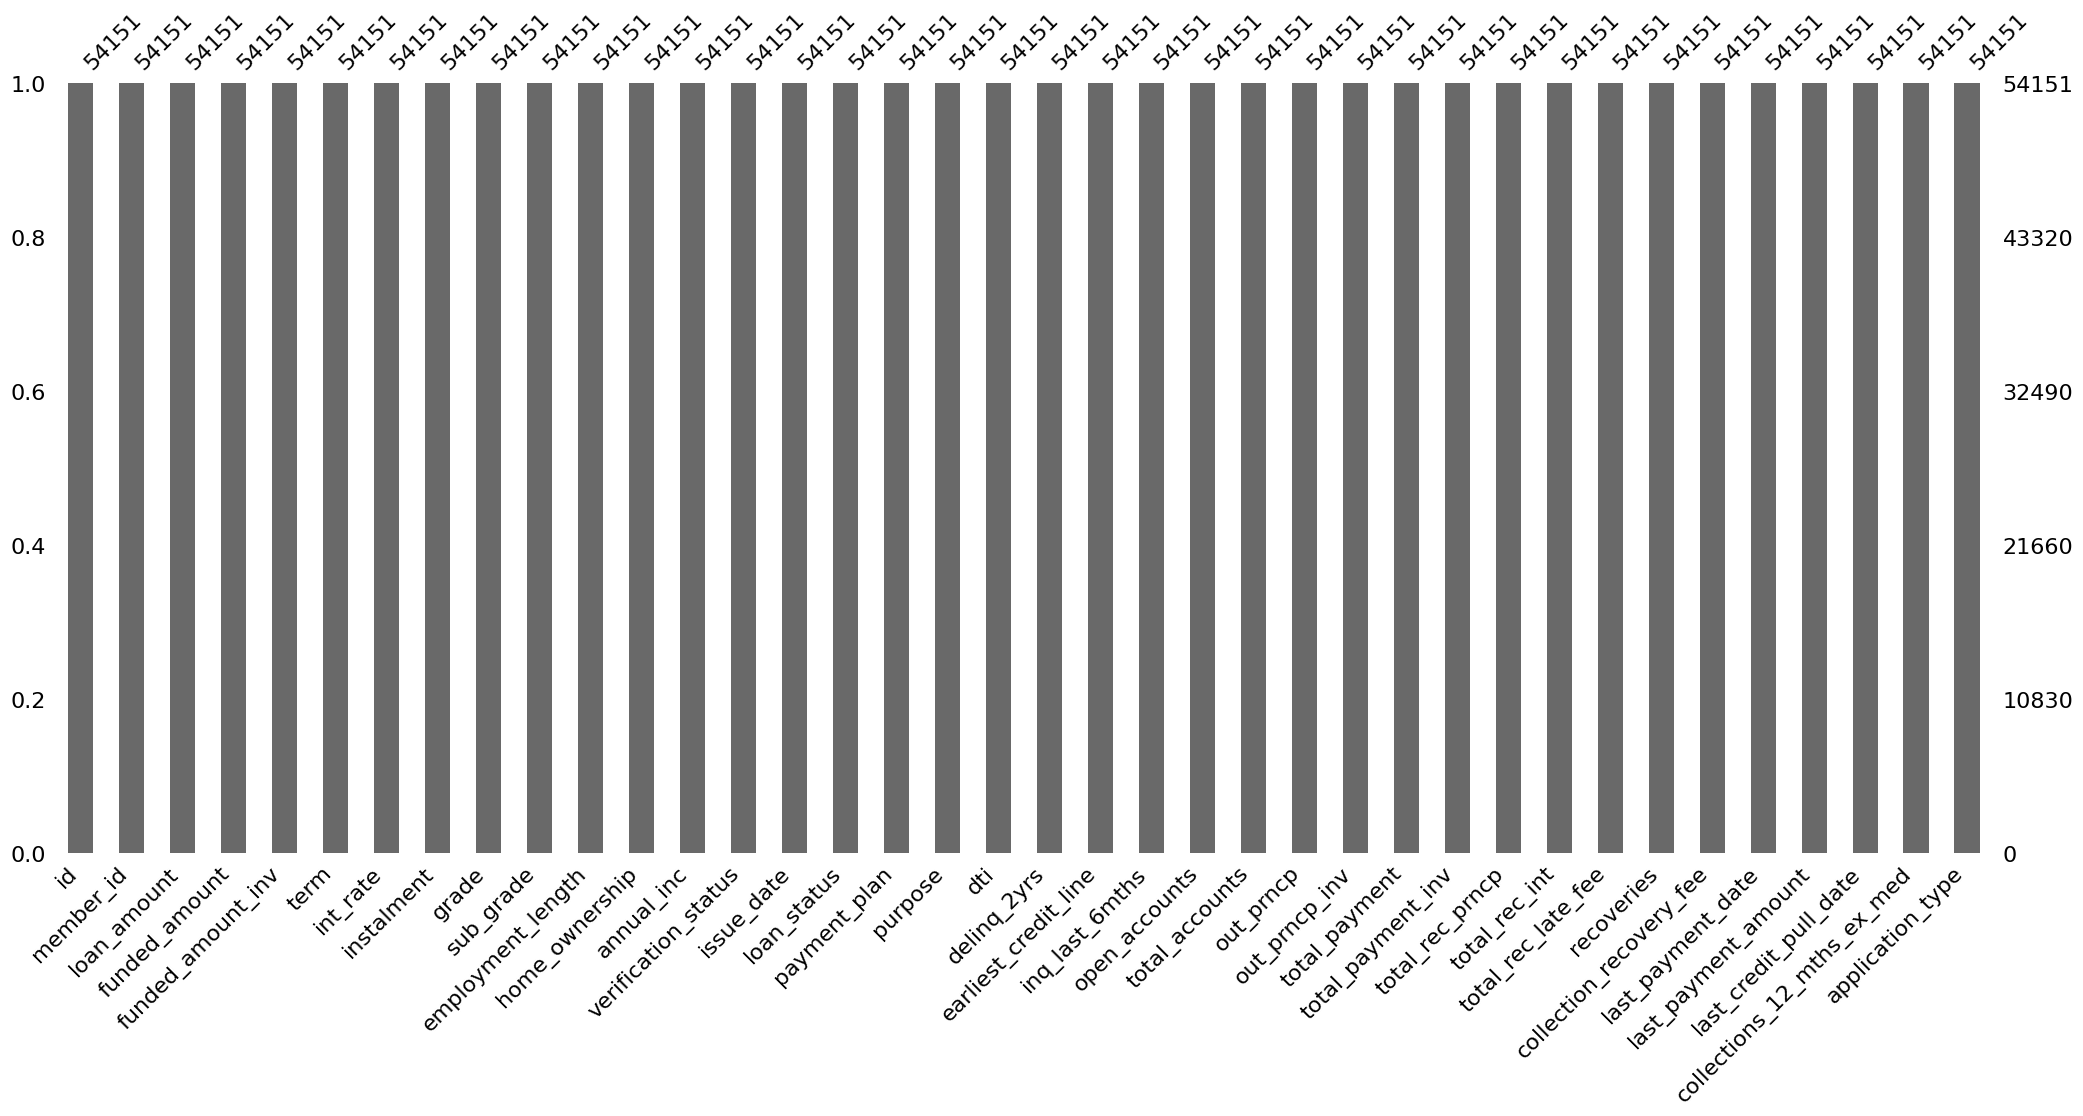

In [69]:
plotter.show_null_bar_chart(df)

### Skewed data

Lets first look at the skew value for each of the columns

In [70]:
# get a series showing the skew value for each column
skew_series = df_info.measure_skew_for_all_columns(df).sort_values(ascending=False)

# drop the two id columns since they are not to be changed anyway so skew is irrelevent
skew_series = skew_series.drop(['id', 'member_id'])

# construct a dataframe with these columns
skew_df = df[list(skew_series.index)]

skew_df

,last_payment_amount,out_prncp_inv,out_prncp,total_rec_int,total_payment,total_rec_prncp,total_payment_inv,open_accounts,instalment,funded_amount,funded_amount_inv,loan_amount,total_accounts,int_rate,dti
0,248.82,5529.70,5529.70,512.21,2982.51,2470.30,2982.51,12,248.82,8000.0,8000.0,8000,27,7.49,19.54
1,407.52,9102.83,9102.83,787.94,4885.11,4097.17,4885.11,15,407.52,13200.0,13200.0,13200,31,6.99,24.20
2,12850.16,0.00,0.00,824.54,16824.54,16000.00,16824.54,7,497.63,16000.0,16000.0,16000,18,7.49,16.92
3,13899.67,0.00,0.00,947.47,15947.47,15000.00,15947.47,6,514.93,15000.0,15000.0,15000,13,14.31,35.52
4,456.54,10297.47,10297.47,770.93,5473.46,4702.53,5473.46,23,456.54,15000.0,15000.0,15000,50,6.03,3.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,160.61,0.00,0.00,724.82,5724.82,5000.00,2032.29,5,159.03,5000.0,1775.0,5000,7,9.01,10.00
54227,490.01,0.00,0.00,826.31,5931.25,5000.00,2787.47,6,162.73,5000.0,2350.0,5000,6,10.59,24.40
54228,110.58,0.00,0.00,415.37,3915.37,3500.00,2489.01,8,108.77,3500.0,2225.0,3500,18,7.43,1.00
54229,0.00,0.00,0.00,174.18,5174.18,5000.00,232.84,2,155.38,5000.0,225.0,5000,2,7.43,0.28


In [71]:
skew_series

last_payment_amount    2.497220
out_prncp_inv          2.354471
out_prncp              2.354051
total_rec_int          2.204585
total_payment          1.269875
total_rec_prncp        1.262679
total_payment_inv      1.257870
open_accounts          1.059184
instalment             0.996572
funded_amount          0.869634
funded_amount_inv      0.813376
loan_amount            0.804922
total_accounts         0.779040
int_rate               0.456620
dti                    0.189101
dtype: float64

In order to decide a cut off point for considering a column as skewed, I will look into those which appear to be normally distributed. 

The table above shows the skewness of the numeric features, sorted with the highest first. 

The closer a skew value is to 0, the more normally distributed it is; those lower in the table have the least skew.

To determine a cuttoff point for skewness *I will look at the kde histplot for each of the **last 4** values in the table*, focusing on how the rise in the skew value affects the extend of the skew. 

In [72]:
last_4_skew_cols = skew_series.tail(4)
last_four_names = [str(col_name) for col_name in last_4_skew_cols.index]
last_4_skew_cols

loan_amount       0.804922
total_accounts    0.779040
int_rate          0.456620
dti               0.189101
dtype: float64

Histplot for loan_amount which has a skew of 0.805


<Axes: xlabel='loan_amount', ylabel='Count'>

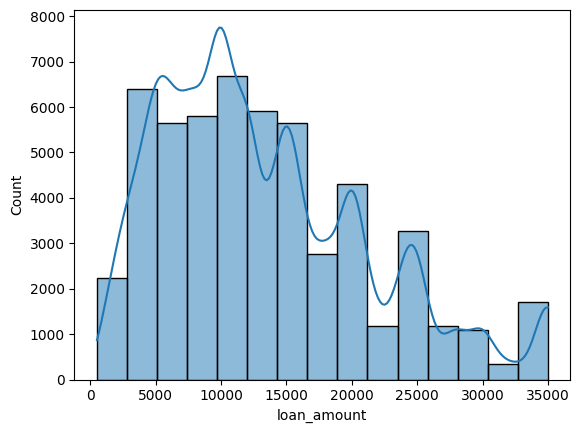

In [73]:
column_name = last_four_names[0]

print(f"Histplot for {column_name} which has a skew of {round(last_4_skew_cols[0], 3)}")

plotter.histogram(df[column_name], 15, True)

Histplot for total_accounts which has a skew of 0.779


<Axes: xlabel='total_accounts', ylabel='Count'>

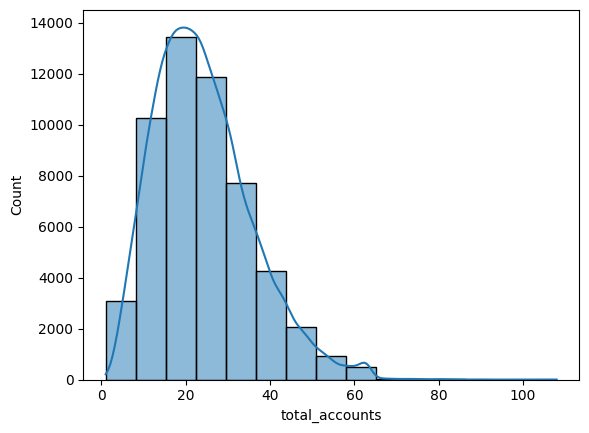

In [74]:
column_name = last_four_names[1]

print(f"Histplot for {column_name} which has a skew of {round(last_4_skew_cols[1], 3)}")

plotter.histogram(df[column_name], 15, True)

Histplot for int_rate which has a skew of 0.457


<Axes: xlabel='int_rate', ylabel='Count'>

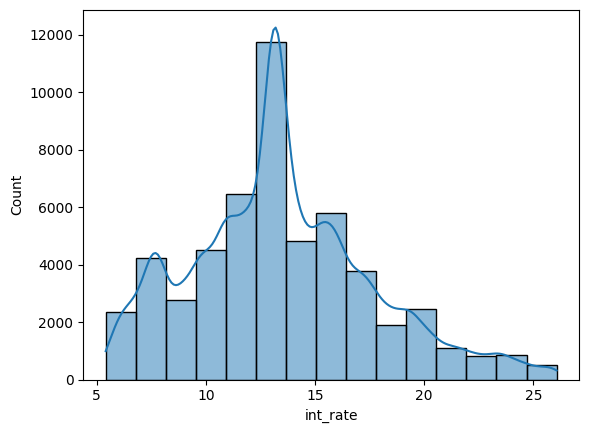

In [75]:
column_name = last_four_names[2]

print(f"Histplot for {column_name} which has a skew of {round(last_4_skew_cols[2], 3)}")

plotter.histogram(df[column_name], 15, True)

Histplot for dti which has a skew of 0.189


<Axes: xlabel='dti', ylabel='Count'>

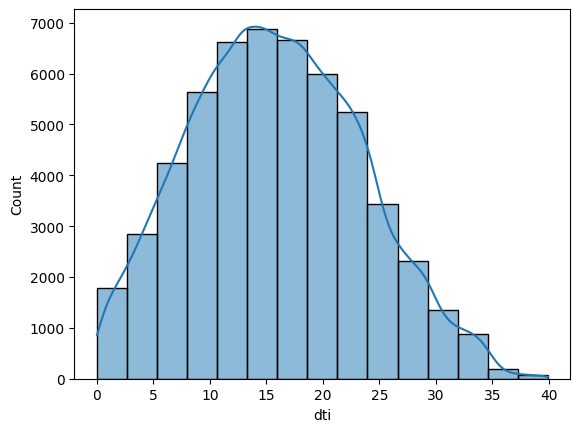

In [76]:
column_name = last_four_names[3]

print(f"Histplot for {column_name} which has a skew of {round(last_4_skew_cols[3], 3)}")

plotter.histogram(df[column_name], 15, True)

Looking at the above I notice that the lowest skew values at which skewness becomes apparent is 0.78 for the total_accounts column.

The next lowest is int_rate with a value of 0.456, and that looks normally distributed enough. 

As a result I am going to set my skew_threshold at 0.5.

#### Transform skewed columns 

Let's see the columns and their skews after applying the skew threshold.

In [77]:
SKEW_THRESHOLD = 0.5

# This will remove int_rate and dti since they are symmetric enough already.
skew_series = skew_series[skew_series > SKEW_THRESHOLD]
skew_series

last_payment_amount    2.497220
out_prncp_inv          2.354471
out_prncp              2.354051
total_rec_int          2.204585
total_payment          1.269875
total_rec_prncp        1.262679
total_payment_inv      1.257870
open_accounts          1.059184
instalment             0.996572
funded_amount          0.869634
funded_amount_inv      0.813376
loan_amount            0.804922
total_accounts         0.779040
dtype: float64

In [78]:
# construct a dataframe with these columns
skew_df = df[list(skew_series.index)]

skew_df

,last_payment_amount,out_prncp_inv,out_prncp,total_rec_int,total_payment,total_rec_prncp,total_payment_inv,open_accounts,instalment,funded_amount,funded_amount_inv,loan_amount,total_accounts
0,248.82,5529.70,5529.70,512.21,2982.51,2470.30,2982.51,12,248.82,8000.0,8000.0,8000,27
1,407.52,9102.83,9102.83,787.94,4885.11,4097.17,4885.11,15,407.52,13200.0,13200.0,13200,31
2,12850.16,0.00,0.00,824.54,16824.54,16000.00,16824.54,7,497.63,16000.0,16000.0,16000,18
3,13899.67,0.00,0.00,947.47,15947.47,15000.00,15947.47,6,514.93,15000.0,15000.0,15000,13
4,456.54,10297.47,10297.47,770.93,5473.46,4702.53,5473.46,23,456.54,15000.0,15000.0,15000,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,160.61,0.00,0.00,724.82,5724.82,5000.00,2032.29,5,159.03,5000.0,1775.0,5000,7
54227,490.01,0.00,0.00,826.31,5931.25,5000.00,2787.47,6,162.73,5000.0,2350.0,5000,6
54228,110.58,0.00,0.00,415.37,3915.37,3500.00,2489.01,8,108.77,3500.0,2225.0,3500,18
54229,0.00,0.00,0.00,174.18,5174.18,5000.00,232.84,2,155.38,5000.0,225.0,5000,2


First I am going to transform the column with the least skew:

`total_accounts` has a skew of `0.779`

In [79]:
# get the Series for the column with the lowest skew
skew_col_names = list(skew_series.index)
least_skewed_col_name: str = skew_col_names[len(skew_col_names) - 1]
least_skewed_col = df[least_skewed_col_name]

Before


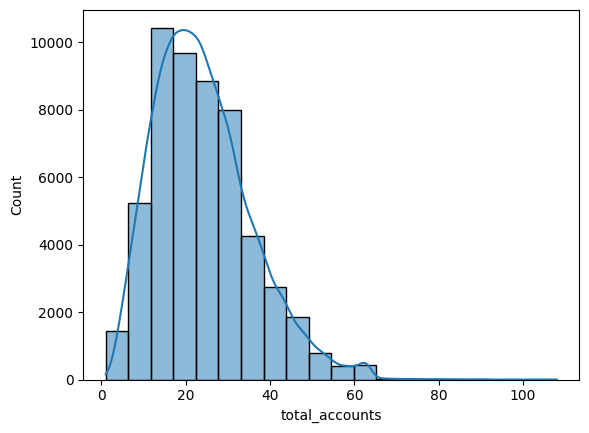

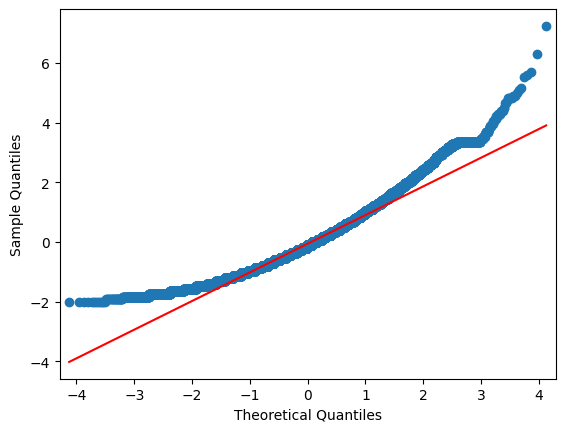

In [80]:
print("Before")
plotter.histogram(least_skewed_col, 20, True)
plotter.qq_plot(least_skewed_col)

In [81]:
# transformed_column = least_skewed_col.map(lambda i: np.log(i) if i > 0 else 0)

least_skewed_col = df_transformer.box_cox_transform(least_skewed_col)


After


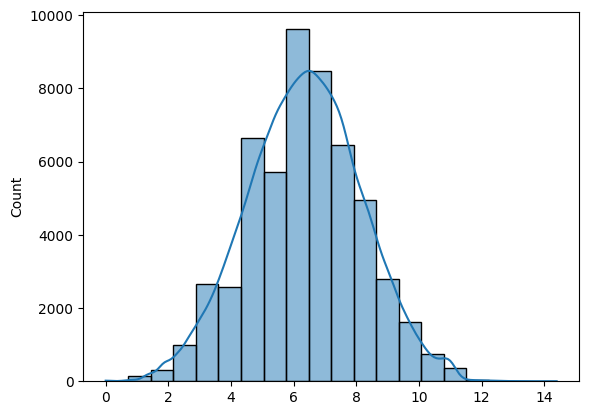

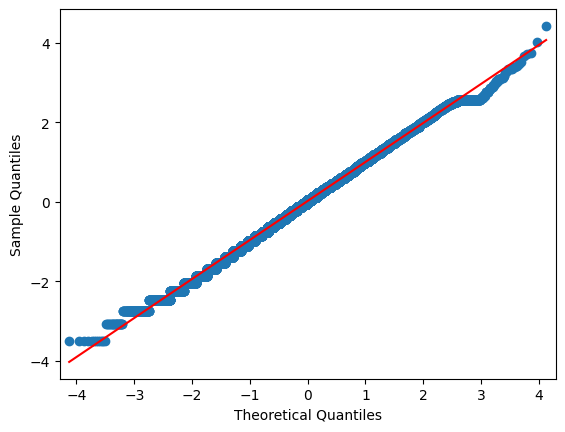

In [82]:
print("After")
plotter.histogram(least_skewed_col, 20)
plotter.qq_plot(least_skewed_col)